<a href="https://colab.research.google.com/github/gusanagy/DeepLabV3/blob/main/DeeplabV3%2B_Autoceres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DeeplabV3+

1. Organizar codigo


2. Funcoes de melhoria
  * Adicionar funcao que salva as predições  (*Checkpoint*)
  * Adicionar func que carrega as predições (*Load Checkpoint*)
  * adicionar funcoes de augumentation

3. Funcoes de avaliacao
  * investigar tensor boards para avaliações
  * Ajustar metricas de avaliação
  Por slgum moptivo os calculos das metricas nao estao corretos

5. Atualizar no github

6. Quanto aos canais de cor na classificacao binaria
 * A comparacao da predicao e da label nesse caso compara tres canais de cores com dois canais numa classicificação binaria. Como interpretar este fato. Afinal para calcular acuracia os dados devem tero mesmo formato.

* [Deeplabv3 artigo](https://arxiv.org/abs/1706.05587)


##Bibliotecas usadas

In [ ]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm import tqdm_notebook as tqdm
from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#from albumentations import Compose, HorizontalFlip, ChannelShuffle, Resize, CoarseDropout, Rotate, Equalize, RandomShadow, CenterCrop, RandomBrightnessContrast, HorizontalFlip, CLAHE, Normalize
#from albumentations.augmentations.geometric.resize import Resize as
from albumentations.pytorch import ToTensorV2
import albumentations as A

import torch
from torch import optim
from torch import nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import SubsetRandomSampler

from torchvision import datasets
from torchvision.transforms import ToTensor, Resize
from torchvision.io import read_image
from torchvision.transforms import ConvertImageDtype
from torchvision import datasets, transforms
#from torchvision.transforms import Compose
from torchvision import transforms
from torchvision.utils import save_image

from tqdm.auto import tqdm
from timeit import default_timer as timer

### Helper functions

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)



In [ ]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time. """
  total_time = end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

### Wandb


In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=53b4288d9fb45cd64d3313dd37ad80d40da4c70dbb7e8aa88e55afaa4d4e0f7b
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import wandb
wandb.login()
wandb.init(
  project="DeepLabV3",
)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gusanagy (autoceres). Use `wandb login --relogin` to force relogin


## Montar Drive

In [ ]:

# montar Google Drive / mount Google drive
# será solicitadas as credenciais do usuario
# do gmail
drive.mount('/content/gdrive/',force_remount=True)
#ir para pasta conhecimento
path = '/content/gdrive/MyDrive/DeepLabV3Plus-Pytorch/'
#ir para pasta conhecimento
os.chdir(path)

#listar arquivos da pasta
!ls -A

Mounted at /content/gdrive/
checkpoints  fulldividido  Heart.csv		main.py  predict.py   requirements.txt	wandb
dataset      .git	   helper_functions.py	metrics  __pycache__  samples
datasets     .gitignore    LICENSE		network  README.md    utils


##Data Augmentation extra // Não rodar

In [ ]:
""" Diretório """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path, split = 0.25):
    """ Carregamento das imagens e máscaras """
    X = sorted(glob(os.path.join(path, "/content/gdrive/MyDrive/DeepLabV3Plus-Pytorch/datasets/Dataset_Strawberry/images", "*.png")))
    Y = sorted(glob(os.path.join(path, "/content/gdrive/MyDrive/DeepLabV3Plus-Pytorch/datasets/Dataset_Strawberry/masks", "*.png")))

    split_size = int(len(X) * split)

    train_x, test_x = train_test_split(X, test_size = split_size, random_state = 42)
    train_y, test_y = train_test_split(Y, test_size = split_size, random_state = 42)

    return (train_x, train_y), (test_x, test_y)
def augment_data(images, masks, save_path, augment = True):
    H = 512
    W = 512

    for x, y in tqdm(zip(images, masks), total = len(images)):
        name = x.split("/")[-1].split(".")[0]

        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        """ Data Augmentation """
        if augment == True:
            aug = HorizontalFlip(p = 1.0) #Flip horizontal
            augmented = aug(image = x, mask = y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            x2 = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
            y2 = y

            """
            aug = ChannelShuffle(p = 1) #Reorganiza aleatoriamente os canais da imagem RGB de entrada.
            augmented = aug(image = x, mask = y)
            x3 = augmented['image']
            y3 = augmented['mask']
            """

            aug = CoarseDropout(p = 1, min_holes = 3, max_holes = 10, max_height = 32, max_width = 32) #Dropa uma caixa de pixels 32x32 da imagem, pode simular possíveis falhas na linha de plantação
            augmented = aug(image = x, mask = y)
            x4 = augmented['image']
            y4 = augmented['mask']

            """
            aug = Rotate(limit = 45, p = 1.0) #Rotaciona a imagem de entrada
            augmented = aug(image = x, mask = y)
            x5 = augmented["image"]
            y5 = augmented["mask"]
            """

            aug = Equalize(p = 1.0) #Equaliza a imagem de entrada
            augmented = aug(image = x, mask = y)
            x5 = augmented["image"]
            y5 = augmented["mask"]

            """
            aug = RandomShadow(shadow_roi = (0, 0.5, 1, 1), num_shadows_lower = 1, num_shadows_upper = 1, shadow_dimension = 4, always_apply = False, p=1) #Cria sombras nas imagens
            augmented = aug(image = x, mask = y)
            x6 = augmented["image"]
            y6 = augmented["mask"]
            """

            aug = RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1.5) #Brilho aleatório
            augmented = aug(image = x, mask = y)
            x6 = augmented["image"]
            y6 = augmented["mask"]

            X = [x, x1, x2, x4, x5, x6]
            Y = [y, y1, y2, y4, y5, y6]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            try:
                aug = CenterCrop(H, W, p = 1.0)
                augmented = aug(image = i, mask = m)
                i = augmented["image"]
                m = augmented["mask"]

            except Exception as e:
                i = cv2.resize(i, (W, H))
                m = cv2.resize(m, (W, H))

            tmp_image_name = f"{name}_{index}.png"
            tmp_mask_name = f"{name}_{index}.png"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

### Data Augmentation Main

In [ ]:
# if __name__ == "__main__":
#     np.random.seed(42)

#     """ Carregamento do Dataset """
#     data_path = "datasets"

#     (train_x, train_y), (test_x, test_y) = load_data(data_path)

#     print(f"Train:\t {len(train_x)} - {len(train_y)}")
#     print(f"Test:\t {len(test_x)} - {len(test_y)}")

    # """ Criando os diretórios para o Data Augmentation """
    # create_dir("/dataset/new_data/train/image/")
    # create_dir("/dataset/new_data/train/mask/")
    # create_dir("/dataset/new_data/test/image/")
    # create_dir("/dataset/new_data/test/mask/")

    # augment_data(train_x, train_y, "/dataset/new_data/train/", augment = True)
    # augment_data(test_x, test_y, "/dataset/new_data/test/", augment = True)#Substitui por True

## Setup DataLoader

### Endereço para o dataset Augumentado com a lib augumentations

In [ ]:
#diretório das imagens de treino
TRAIN_IMG_DIR = "fulldividido/treino /images"
#diretório das máscaras de treino
TRAIN_MASK_DIR = "fulldividido/treino /masks"
#diretório das imagens de teste
VAL_IMG_DIR = "fulldividido/teste/images"
#diretório das máscaras de teste
VAL_MASK_DIR = "fulldividido/teste/masks"

#Caso fosse utilizar o dataset sem augumentar
DIR_X = "datasets/Dataset_Strawberry/images/"
DIR_y = "datasets/Dataset_Strawberry/masks/"

print(f"""
          Dir of X / no aug:     {DIR_X}
          Dir of y / no aug:     {DIR_y}
          Dir train x:  {TRAIN_IMG_DIR}
          Dir train y:  {TRAIN_MASK_DIR}
          Dir test x:   {VAL_IMG_DIR}
          Dir test y:   {VAL_MASK_DIR}""")



          Dir of X / no aug:     datasets/Dataset_Strawberry/images/
          Dir of y / no aug:     datasets/Dataset_Strawberry/masks/
          Dir train x:  fulldividido/treino /images
          Dir train y:  fulldividido/treino /masks
          Dir test x:   fulldividido/teste/images
          Dir test y:   fulldividido/teste/masks


### Classe Custom Dataset

In [ ]:
class AgroDataset(Dataset):
    def __init__(self, img_dir_x, img_dir_y, transform=None):
        self.img_dir_x = img_dir_x
        self.img_dir_y = img_dir_y
        self.train_transform = transform
        self.images = os.listdir(img_dir_x)

    def __len__(self):
        return len(self.img_dir_x)

    def __getitem__(self, idx):
        img_path_x = os.path.join(self.img_dir_x,self.images[idx].replace(".jpg", ".png"))
        img_path_y = os.path.join(self.img_dir_y,self.images[idx].replace(".jpg", ".png"))
        image_x =  np.array(Image.open(img_path_x).convert("RGB"))#Modifique para nao carretgar imagens rgb
        label_mask_y = np.array(Image.open(img_path_y).convert("L"), dtype=np.float32)

        #label_mask_y = label_mask_y.repeat(3, 1, 1)
        #image_x = read_image(img_path_x)#.numpy().dtype(np.int32)
        #label_mask_y = read_image(img_path_y)#.numpy().dtype(np.int32)
        #label_mask_y = Image.open(img_path_y)
        #image_x = Image.open(img_path_x)
        #label = os.path.basename(X_train[idx])
        label_mask_y[label_mask_y == 255.0] = 1.0

        #convert_to_binary = lambda x: 1.0 if x == 255 else 0.0
        #resultado = list(map(convert_to_binary, label_mask_y))

        if self.train_transform is not None:
          algumentation = self.train_transform(image = image_x, mask = label_mask_y)
        return algumentation["image"], algumentation["mask"]
    # classmethod
    # def decode_target(cls, mask):
    #     """decode semantic mask to RGB image"""
    #     return cls.cmap[mask]


In [ ]:
# def one_hot_encode(label, label_values):
#     """
#     Convert a segmentation image label array to one-hot format
#     by replacing each pixel value with a vector of length num_classes
#     # Arguments
#         label: The 2D array segmentation image label
#         label_values

#     # Returns
#         A 2D array with the same width and hieght as the input, but
#         with a depth size of num_classes
#     """
#     semantic_map = []
#     for colour in label_values:
#         equality = np.equal(label, colour)
#         class_map = np.all(equality, axis = -1)
#         semantic_map.append(class_map)
#     semantic_map = np.stack(semantic_map, axis=-1)

#     return semantic_map

###Instancia a Classe e carrega os dados do Dataset

In [ ]:
def Get_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE=8,
    NUM_WORKERS=4,
    PIN_MEMORY=True,
    IMAGE_HEIGHT = 160,
    IMAGE_WIDTH = 240):


  train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=0.3),                        #Rotaciona em até 35 graus
            A.HorizontalFlip(p=1.0),                          #Espelha horizontalmente com probabilidade de 0,5
            A.CLAHE(p=0.2),                                   #ajuda a melhorar a visibilidade de detalhes em regiões escuras ou claras da imagem.
            A.Normalize(                   #normaliza os valores de pixel da imagem para ter média 0 e desvio padrão 1
                mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),     #converte a imagem para o formato tensor
        ],
    )

  test_transform = A.Compose(
      [
          A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),   #redimensiona a imagem
          A.Normalize(
              mean=[0.5, 0.5, 0.5],
              std=[0.5, 0.5, 0.5],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ],
  )

  # # Definir transformações para o DataLoader
  # train_transform = transforms.Compose(
  #                               [
  #                               transforms.ToPILImage(),
  #                               transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
  #                               transforms.ToTensor(),
  #                               #transforms.Lambda(lambda x: torch.cat([x, x, x], dim=0)),
  #                               #transforms.Lambda(lambda x: 1.0 if x == 255.0 else x / 255.0),
  #                               transforms.ConvertImageDtype(torch.float),
  #                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  #                               #transforms.Normalize((0.485), (0.229)),
  #                               ]
  # )
  # test_transform = transforms.Compose(
  #                               [
  #                               transforms.ToPILImage(),
  #                               transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
  #                               transforms.ToTensor(),
  #                               #transforms.Lambda(lambda x: torch.cat([x, x, x], dim=0)),
  #                               #transforms.Lambda(lambda x: 1.0 if x == 255.0 else x / 255.0),
  #                               transforms.ConvertImageDtype(torch.float),
  #                               #transforms.Normalize((0.5), (0.5))
  #                               ]
  # )

  data_train = AgroDataset( img_dir_x = TRAIN_IMG_DIR,
                            img_dir_y = TRAIN_MASK_DIR,
                            transform = train_transform,
                            #transform = ConvertImageDtype(torch.int),
                            #target_transform = ConvertImageDtype(torch.int)
                                )
  data_test = AgroDataset(  img_dir_x = VAL_IMG_DIR,
                            img_dir_y = VAL_MASK_DIR,
                            transform = test_transform,
                            #transform = ConvertImageDtype(torch.int),
                            #target_transform = ConvertImageDtype(torch.int)
                                )

  train_dataloader = DataLoader(
                                data_train,
                                shuffle=True,
                                batch_size=BATCH_SIZE,
                                num_workers=NUM_WORKERS,
                                drop_last=True
                                )

  test_dataloader  = DataLoader(
                                data_test,
                                shuffle=True,
                                batch_size=BATCH_SIZE,
                                num_workers=NUM_WORKERS
                                )

  return train_dataloader, test_dataloader

### Testando Num_worker

https://chtalhaanwar.medium.com/pytorch-num-workers-a-tip-for-speedy-training-ed127d825db7

In [ ]:
# from time import time
# import multiprocessing as mp
# for num_workers in range(2, mp.cpu_count(), 2):
#     train_loader , _ = Get_loaders(TRAIN_IMG_DIR = TRAIN_IMG_DIR, \
#                                     TRAIN_MASK_DIR = TRAIN_MASK_DIR, \
#                                     VAL_IMG_DIR = VAL_IMG_DIR, \
#                                     VAL_MASK_DIR = VAL_MASK_DIR, \
#                                     BATCH_SIZE=8, \
#                                     NUM_WORKERS=num_workers, \
#                                     PIN_MEMORY=True)
#     start = time()
#     for epoch in range(1, 3):
#         for (X,y) in train_loader:
#             pass
#     end = time()
#     print("Finish with:{} second, num_workers={}".format(end - start, num_workers))



### Setup Agnostic code

In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Importa DeepLabV3+




In [ ]:
# import network as net
# #é diferente desta maneira que eu fiz ver codigo fonte do git
# model = net.deeplabv3plus_resnet101()
# net.convert_to_separable_conv(model.classifier)
# model = model.to(device)
# #utils.set_bn_momentum(model.backbone, momentum=0.01)
# #model.state_dict()

In [ ]:
#model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# or any of these variants
#model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True,)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
#model.eval()
#model.to(device)

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet101 as deeplabv3_resnet101
model = deeplabv3_resnet101(num_classes=1)
#model.to("cpu")
#next(model.parameters()).device
model.to(device);

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 64.8MB/s]


# Main

###Setup Loss and Optimizer

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
#torch.optim.lr_scheduler.StepLR(optimizer, step_size= , gamma= )
criterion = nn.BCEWithLogitsLoss()

### Metricas


In [ ]:
#analise dos resultados
def iou_score(preds, targets, smooth=1e-6):
    #print(preds.shape, targets.shape)
    assert preds.shape == targets.shape, "As dimensões de preds e targets devem ser iguais."

    preds = preds > 0.5
    targets = targets > 0.5

    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    iou = (intersection) / (union + smooth)

    return iou

def dice_score(preds, targets, smooth=1e-6):
    intersection = torch.logical_and(preds, targets).sum()
    union = preds.sum() + targets.sum()
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice

def recall(preds, targets, smooth=1e-6):
   #binariza as previsões e os alvos
    preds = preds > 0.5
    targets = targets > 0.5

    # calcula o número de verdadeiros positivos e falsos negativos
    true_positives = torch.logical_and(preds, targets).sum()
    false_negatives = targets.sum() - true_positives

     # calcula o recall com suavização para evitar divisão por zero
    recall_value = true_positives / (true_positives + false_negatives + smooth)
    return recall_value

def falso_positivo(preds, targets, smooth=1e-6):
    #binarizo as previsões e alvos
    preds = preds > 0.5 #qualquer valor acima de 0.5 é positivo e abaixo de 0.5 é negativo
    targets = targets > 0.5

    falsos_positivos = (preds > targets).sum()  #calcula o número de falsos positivos

    verdadeiros_negativos = (~preds & ~targets).sum()  #uso ~como negativo, ou seja quando ambos são 0, tanto a máscara como a predição.

    fpr = falsos_positivos.sum() / (falsos_positivos.sum() + verdadeiros_negativos.sum() + smooth)    #fórmula + smooth para evitar divisão por 0
    return fpr

def falso_negativo(preds, targets, smooth=1e-6):
    #binarizo as previsões e alvos
    preds = preds > 0.5 #qualquer valor acima de 0.5 é positivo e abaixo de 0.5 é negativo
    targets = targets > 0.5

    verdadeiros_positivos = torch.logical_and(targets, preds).sum() #usa essa função lógica do pytorch para calcular os acertos

    falsos_negativos = targets.sum() - verdadeiros_positivos # aqui faço:  o total de positivos certo - o total de positivos acertados = o número de positivos que foi predito como negativos

    fnr = falsos_negativos.sum() / (falsos_negativos.sum() + verdadeiros_positivos.sum() + smooth) #fórmula + smooth para evitar divisão por 0

    return fnr


In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])


def criar_ou_verificar_pasta(folder_name):
    """
    Verifica se uma pasta já existe e, se não existir, cria a pasta.

    Args:
        folder_name (str): Nome da pasta que você deseja criar ou verificar.

    Returns:
        bool: True se a pasta foi criada, False se a pasta já existia.
    """
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
        print(f'A pasta "{folder_name}" foi criada.')
        return True
    else:
        print(f'A pasta "{folder_name}" já existe e não foi criada novamente.')
        return False
def save_predictions_as_imgs(
    loader, model, folder="/content/gdrive/MyDrive/DeepLabV3Plus-Pytorch/checkpoints", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate (loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()


        save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        save_image(y.unsqueeze(1), f"{folder}/true_{idx}.png")
    model.train()

In [ ]:
def test_model():
    x = torch.rand((3, 3, 255, 255)).to(device)
    preds = model(x)['out']
    print(preds.shape)
    print(x.shape)
    #assert preds.shape == x.shape
test_model()

torch.Size([3, 1, 255, 255])
torch.Size([3, 3, 255, 255])


In [ ]:
def train_step(model,
               data_loader,
               loss_fn,
               optimizer,
               device,
               scaler):

  train_loss = 0.0
  model.train()

  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.unsqueeze(1).to(device)#.type(torch.long).to(device)

    with torch.cuda.amp.autocast():
      y_pred = model(X)['out']
      loss = loss_fn(y_pred, y)
      # print(f"""
      #       {y_pred.shape}
      #       {y.shape}
      #       """)


    train_loss += loss
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    # train_acc /= len(data_loader.Dataset)
    if batch % 5 == 0:
      print(f"""Batch: {batch}
      Train loss: {train_loss/len(data_loader):.5f}
            loss: {train_loss}
            """)
    wandb.log({"train_loss": train_loss/len(data_loader)})
      #print("checkpoint")


def test_step(data_loader,
              model,
              loss_fn,
              device):
  """
  Perform a testing loop step on model going over data_loader.
  """
  num_correct = 0
  num_pixels = 0
  dice_score_total = 0
  iou = 0.0
  recall_total = 0.0
  fpr_total = 0.0
  fnr_total = 0.0


  model.eval()
  # Turn on inference context manager
  with torch.no_grad():
    for X, y in data_loader:
      X, y = X.to(device), y.unsqueeze(1).to(device)#.type(torch.long).to(device)

      test_pred = model(X)['out']
      loss = loss_fn(test_pred, y)
      preds = torch.sigmoid(test_pred)
      #print(preds.shape)
      #preds = torch.sum(preds, dim=1)
      #print(preds.shape)
      preds = (preds > 0.5).float() # Aplicação de threshold

      # contagem de pixels corretos
      num_correct = torch.sum((preds == y).float()).item()
      num_pixels += torch.numel(preds)

      # cálculo das métricas
      dice_score_total += dice_score(preds, y)
      iou += iou_score(preds, y)
      recall_total += recall(preds, y)
      fpr_total += falso_positivo(preds, y)
      fnr_total += falso_negativo(preds, y)

  # """Métricas no wandb"""
  wandb.log({"Acuracy": num_correct / num_pixels, "Dice_score": dice_score_total / len(data_loader), "IOU_score": iou / len(data_loader), "Recall": recall_total / len(data_loader)})
  wandb.log({"Falso positivo": fpr_total / len(data_loader), "Falso Negativo": fnr_total / len(data_loader)})

  print(f"""
      Validação

    |tamanho data loader|:        {len(data_loader)}
    | Pixeis corretos |:          {num_correct:.4f}/
    | Acc |:                      {num_correct / num_pixels * 100:.4f}
    | Dice Score|:                {dice_score_total / len(data_loader):.4f}
    | IoU Score|:                 {iou / len(data_loader):.4f}
    | Recall|:                    {recall_total / len(data_loader):.4f}
    | Taxa de falsos positivos|:  {fpr_total/ len(data_loader):.4f}
    | Taxa de falsos Negativos|:  {fnr_total/ len(data_loader):.4f}""")



def eval_model(model,
               data_loader,
               loss_fn,
               accuracy_fn):
  """
  Returns a dictionary containing the results of model predictiong on data_loader.
  """

  loss, acc = 0, 0
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.squeeze(1).type(torch.long).to(device)
      y_pred = model(X)['out']
      loss += loss_fn(y_pred, y)

    #Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc
          }


## Data


In [ ]:
#criar_ou_verificar_pasta("checkpoints")
!ls

checkpoints  fulldividido	  LICENSE  network	README.md	  utils
dataset      Heart.csv		  main.py  predict.py	requirements.txt  wandb
datasets     helper_functions.py  metrics  __pycache__	samples


In [ ]:
train_dataloader, test_dataloader = Get_loaders(TRAIN_IMG_DIR = TRAIN_IMG_DIR, \
                                                TRAIN_MASK_DIR = TRAIN_MASK_DIR, \
                                                VAL_IMG_DIR = VAL_IMG_DIR, \
                                                VAL_MASK_DIR = VAL_MASK_DIR, \
                                                BATCH_SIZE=8, \
                                                NUM_WORKERS=4, \
                                                PIN_MEMORY=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Test Dataloader

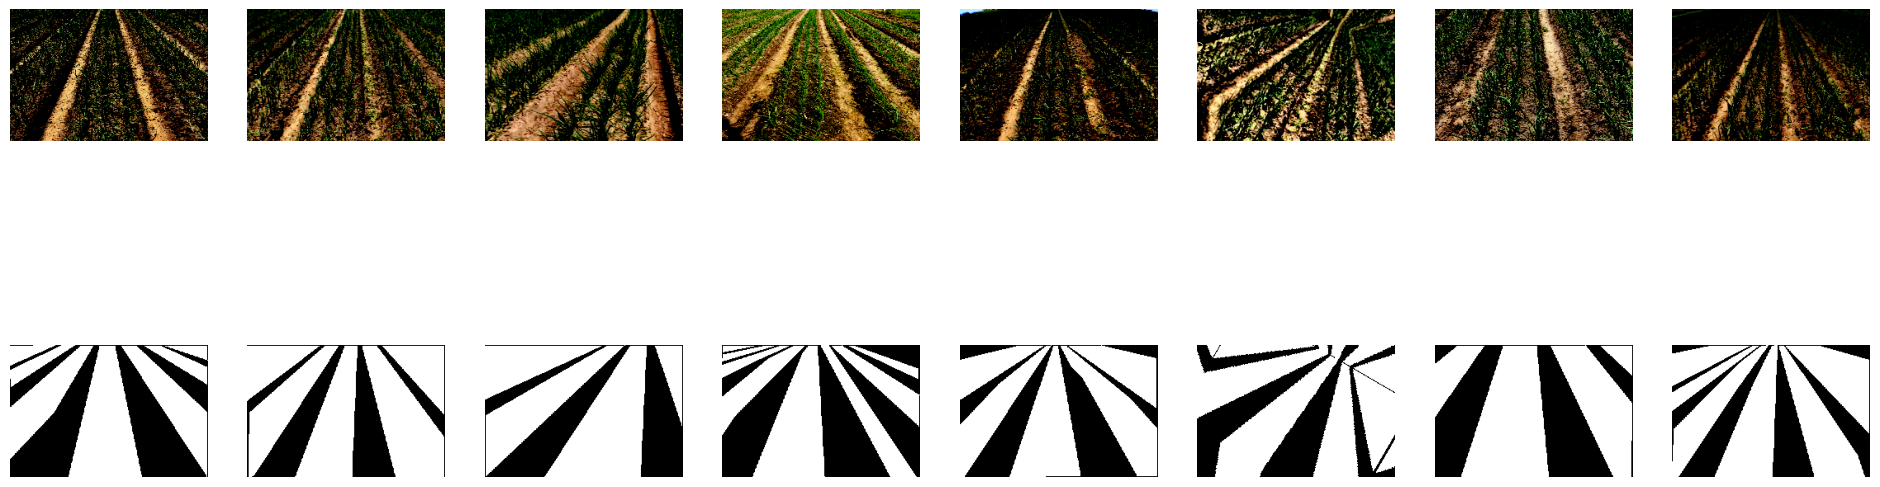

In [ ]:
def plot_batch_with_masks(dataloader, num_images=4):
    # Carregando um batch de dados do DataLoader
    dataiter = iter(dataloader)
    images, masks = next(dataiter)

    # Definindo transformações para as imagens e máscaras (se necessário)
    transform = transforms.ToPILImage()

    # Configuração da figura para exibir as imagens
    plt.figure(figsize=(24, 8))

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        image = images[i].numpy().transpose((1, 2, 0))
        #image = transform(image)  # Se necessário, transforme o tensor de imagem em uma imagem PIL
        plt.imshow(image, cmap='BrBG')
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        mask = masks[i].numpy()
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

    plt.show()

# Exemplo de uso
plot_batch_with_masks(train_dataloader, num_images=8)


## Main


In [ ]:
torch.manual_seed(42)

#Meansure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Parametros
epochs = 1000
scaler = torch.cuda.amp.GradScaler()

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------------\n")
  train_step(model=model,
            data_loader=train_dataloader,
            loss_fn=criterion,
            optimizer=optimizer,
            device=device,
            scaler=scaler)
  test_step(model=model,
            data_loader = test_dataloader,
            loss_fn=criterion,
            device=device)

  train_time_end_on_gpu = timer()
  total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                              end=train_time_end_on_gpu,
                                              device=device)

  0%|          | 0/1000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
    | Taxa de falsos positivos|:  0.4117
    | Taxa de falsos Negativos|:  0.1502
Train time on cuda: 1907.453 seconds
Epoch: 737
------------

Batch: 0
      Train loss: 0.00662
            loss: 0.019848458468914032
            

      Validação

    |tamanho data loader|:        4
    | Pixeis corretos |:          25567.0000/
    | Acc |:                      2.6632
    | Dice Score|:                0.0320
    | IoU Score|:                 0.4485
    | Recall|:                    0.8224
    | Taxa de falsos positivos|:  0.3720
    | Taxa de falsos Negativos|:  0.1776
Train time on cuda: 1910.849 seconds
Epoch: 738
------------

Batch: 0
      Train loss: 0.00546
            loss: 0.016383547335863113
            

      Validação

    |tamanho data loader|:        4
    | Pixeis corretos |:          8702.0000/
    | Acc |:                      0.9065
    | Dice Score|:                0.0343
    | IoU Score|:                 0.4257
 

In [ ]:
import gc

# Limpar a memória da GPU
torch.cuda.empty_cache()

# Coletar lixo para liberar a memória não utilizada
gc.collect()

18

In [ ]:
torch.manual_seed(42)
# Get model_1 results dictionary
model_1_results = eval_model(model=model,
                             data_loader=test_dataloader,
                             loss_fn=criterion,
                             accuracy_fn=accuracy_fn)


  0%|          | 0/4 [00:00<?, ?it/s]

ValueError: ignored

Usar 🇰* https://pytorch.org/vision/stable/models/generated/torchvision.models.segmentation.deeplabv3_resnet101.html#torchvision.models.segmentation.deeplabv3_resnet101